# A Quick View of Model

## View of generation loss distribution

### Loading data

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

data_file='data/creditcard.csv'
data=pd.read_csv(data_file,header=0)

print(data.dtypes.head())
print('Number of records:',len(data))
data.head()

Time    float64
V1      float64
V2      float64
V3      float64
V4      float64
dtype: object
Number of records: 284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Data preprocessing

**NOTE:** The MinMaxScaler instance saved here is be used by the CML/CDSW inferencing engine, as the range of each feature has to be learned from the train set.

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

feature_names=data.columns.values[:-1]
train_test_set = data[data.Class==0][feature_names]
#print(data[data.Class==0][feature_names].to_numpy()[0])
train_set, test_set = train_test_split(train_test_set, test_size=0.2, random_state=42)
scaler=MinMaxScaler().fit(train_set)
file=open('min-max-scaler.pkl','wb')
pickle.dump(scaler,file)
file.close()

ds_fraud=data[data.Class==1][feature_names]
ds_normal=test_set.sample(n=len(ds_fraud),random_state=42)
ds_fraud=scaler.transform(ds_fraud)
ds_normal=scaler.transform(ds_normal)

### Model scoring

In [3]:
class autoencoder(nn.Module):
    def __init__(self,num_input):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_input, 15),
            nn.ReLU(True),
            nn.Linear(15, 7))
        self.decoder = nn.Sequential(
            nn.Linear(7, 15),
            nn.ReLU(True),
            nn.Linear(15, num_input),
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

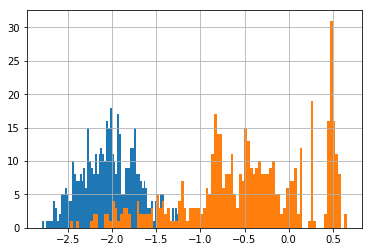

In [4]:
model=autoencoder(len(feature_names))
model.load_state_dict(torch.load('creditcard-fraud-minmaxscale-2.model'))
model.eval()

with torch.no_grad():
    inputs2=torch.tensor(ds_fraud, dtype=torch.float32)
    outputs2=model(inputs2)
    loss2=torch.sum((inputs2-outputs2)**2,dim=1).sqrt().log()

    inputs1=torch.tensor(ds_normal, dtype=torch.float32)
    outputs1=model(inputs1)
    loss1=torch.sum((inputs1-outputs1)**2,dim=1).sqrt().log()

    pd.Series(loss1.numpy()).hist(bins=100)
    pd.Series(loss2.numpy()).hist(bins=100)

## Inferencing with CDSW deployed model

Here is the example of how to inference using the model deployed in CML/CDSW. We'll randomly pick up some records from the data set and compare the predict results with their real results. Here is the code of inferencing with CDSW, and the predicts.

In [5]:
import json, requests

s1=data[data.Class==0].sample(n=10, random_state=42)
s2=data[data.Class==1].sample(n=10, random_state=42)
data_=pd.concat([s1, s2], ignore_index=True)

access_key = 'mctpv79qnql7h9t1ncfeq7v57cwlu65k'
#access_key = 'me0jzyai34gixh97bkmu7ixvo21xndlr'
endpoint = 'https://modelservice.ml-2a091c33-4ac.demo-aws.ylcu-atmi.cloudera.site/model'

predicts=[]
for row in data_[feature_names].to_numpy():
    time=row[0]
    v=row[1:-1].tolist()
    amount=row[-1]
    request={"v": v, "time": time, "amount": amount}
    body={"accessKey":access_key,"request":request}
    r = requests.post(endpoint, data=json.dumps(body), headers={'Content-Type': 'application/json'})
    response = r.json()
    pred = str(response['response']) if r.status_code == 200 else 'FAILED'
    predicts+=[pred]
    print("Time=%s, V1=%s, Amount=%s, Predict=%s"%(time,v[0],amount,pred))

Time=82450.0, V1=1.3145391900561398, Amount=0.76, Predict=False
Time=50554.0, V1=-0.798671774485497, Amount=4.18, Predict=False
Time=55125.0, V1=-0.391128406506541, Amount=15.0, Predict=False
Time=116572.0, V1=-0.0603018544445645, Amount=57.0, Predict=False
Time=90434.0, V1=1.84843255870069, Amount=0.0, Predict=True
Time=39411.0, V1=1.32197869570702, Amount=43.89, Predict=False
Time=100409.0, V1=-0.342387450670689, Amount=49.83, Predict=False
Time=31054.0, V1=1.4590081181326597, Amount=35.0, Predict=False
Time=111675.0, V1=-1.2104755863878, Amount=219.0, Predict=False
Time=18895.0, V1=1.24533658991321, Amount=11.85, Predict=False
Time=28692.0, V1=-29.200328590574397, Amount=99.99, Predict=True
Time=21662.0, V1=-18.0185611876771, Amount=1.0, Predict=True
Time=85285.0, V1=-7.03030814445441, Amount=0.0, Predict=True
Time=91075.0, V1=-1.85506070184998, Amount=38.76, Predict=True
Time=26585.0, V1=-19.856322333443302, Amount=99.99, Predict=True
Time=55760.0, V1=-6.00342167645829, Amount=311.

Let's compare the predicts (*Predict* field) with the real results (*Class* field)

In [6]:
results=data_[['Time','V1','V2','V28','Amount','Class']].copy()
results['Predict']=predicts
results

,Time,V1,V2,V28,Amount,Class,Predict
0,82450.0,1.314539,0.590643,0.031692,0.76,0,False
1,50554.0,-0.798672,1.185093,-0.112901,4.18,0,False
2,55125.0,-0.391128,-0.245540,0.239582,15.00,0,False
3,116572.0,-0.060302,1.065093,0.042330,57.00,0,False
4,90434.0,1.848433,0.373364,-0.042682,0.00,0,True
5,39411.0,1.321979,-0.575195,0.017133,43.89,0,False
6,100409.0,-0.342387,-0.196129,0.324558,49.83,0,False
7,31054.0,1.459008,-1.144243,0.030960,35.00,0,False
8,111675.0,-1.210476,-1.186077,0.029432,219.00,0,False
9,18895.0,1.245337,-0.273576,0.020732,11.85,0,False
